# Random Forest - Open-world Multi-class Scenario (Extra Features)

**Feature 소스**: extra_credit/features/extra_mon_features.pkl, extra_unmon_features.pkl
- **시나리오**: Monitored 사이트 분류 (95개 클래스) + Unmonitored (1개 클래스) = 총 96개 클래스
- **Extra Features 사용**: 모든 17개 extra features 사용


## 1. 라이브러리 및 데이터 로드


In [7]:
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("라이브러리 로드 완료")


라이브러리 로드 완료


In [ ]:
# Load extra features + processed unmonitored data (numpy 2.x 호환 패치)
print("Extra Monitored 데이터 로드 중...")

# numpy 2.x 환경에서 예전 버전으로 저장된 pickle 호환을 위한 패치
import sys
import numpy.core.numeric as _numeric
sys.modules.setdefault('numpy._core.numeric', _numeric)

# Monitored: extra features
mon_features = pd.read_pickle('../../features/extra_mon_features.pkl')
print(f"Monitored 데이터 형태: {mon_features.shape}")

# Unmonitored: processed content 데이터
print("\nProcessed Unmonitored 데이터 로드 중...")
unmon_data = pd.read_pickle('../../features/extra_unmon_features.pkl')
print(f"Processed Unmonitored 데이터 형태: {unmon_data.shape}")
print("데이터 로드 완료!")

Extra Monitored 데이터 로드 중...
Monitored 데이터 형태: (19000, 18)

Extra Unmonitored 데이터 로드 중...
Extra Unmonitored 데이터 형태: (19000, 18)
데이터 로드 완료!


## 2. Feature 선택


In [9]:
# 모든 extra features 사용 (label 제외)
feature_cols = [col for col in mon_features.columns if col != 'label']
selected_features = feature_cols

print(f"선택된 Feature 수: {len(selected_features)}")
print("\nFeature 목록:")
for i, feature in enumerate(selected_features, 1):
    print(f"{i:2d}. {feature}")


선택된 Feature 수: 17

Feature 목록:
 1. total_transmission_time
 2. std_inter_packet_time
 3. avg_outgoing_burst_size
 4. avg_incoming_burst_size
 5. num_outgoing_packets
 6. incoming_packet_ratio
 7. outgoing_packet_ratio
 8. cumul_packets_10pct
 9. cumul_packets_30pct
10. outgoing_order_skew
11. incoming_order_skew
12. cumul_max
13. bigram_OO
14. num_incoming_first_30
15. outgoing_first_30
16. avg_incoming_order_first_30
17. avg_outgoing_order_first_30


## 3. 데이터 준비 (Multi-class Classification)


In [10]:
# Open-world multi: monitored 사이트별 분류 + unmonitored 하나의 클래스로
# Combine mon_features and unmon_features
features_df = pd.concat([mon_features, unmon_features], ignore_index=True)

# Labels: monitored (0-94)은 그대로 유지, unmonitored (-1)은 하나의 클래스로
# Unmonitored를 95번 클래스로 변경 (0-94는 monitored 사이트)
features_df.loc[features_df['label'] == -1, 'label'] = 95

y = features_df['label'].values
X = features_df[selected_features]

print(f"전체 샘플 수: {X.shape[0]}")
print(f"Feature 수: {X.shape[1]}")
print(f"총 클래스 수: {len(np.unique(y))} (Monitored: 95개 사이트 + Unmonitored: 1개 클래스)")
print(f"클래스 범위: {min(y)} ~ {max(y)}")

# 클래스별 샘플 수 확인
class_counts = pd.Series(y).value_counts().sort_index()
print(f"\nMonitored 사이트 샘플 수 (처음 10개):")
print(class_counts.head(10))
print(f"\nUnmonitored 클래스 (클래스 95) 샘플 수: {class_counts[95]}")

# 데이터 분할 (80% 훈련, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n훈련 데이터: {X_train.shape[0]} 샘플")
print(f"테스트 데이터: {X_test.shape[0]} 샘플")


전체 샘플 수: 38000
Feature 수: 17
총 클래스 수: 96 (Monitored: 95개 사이트 + Unmonitored: 1개 클래스)
클래스 범위: 0 ~ 95

Monitored 사이트 샘플 수 (처음 10개):
0    200
1    200
2    200
3    200
4    200
5    200
6    200
7    200
8    200
9    200
Name: count, dtype: int64

Unmonitored 클래스 (클래스 95) 샘플 수: 19000

훈련 데이터: 30400 샘플
테스트 데이터: 7600 샘플


## 4. Random Forest 모델 훈련 및 평가


In [11]:
# 최적 하이퍼파라미터
best_params = {
    'bootstrap': True,
    'max_depth': None,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 200
}

print("최적 하이퍼파라미터:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

# Random Forest 모델 훈련
print("\nRandom Forest 모델 훈련 중...")
rf_clf = RandomForestClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)
print("모델 훈련 완료!")

# 예측
y_pred = rf_clf.predict(X_test)

# 성능 지표 계산
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print("\n" + "="*60)
print("OPEN-WORLD MULTI-CLASS RANDOM FOREST 결과 (Extra Features)")
print("="*60)
print(f"정확도 (Accuracy): {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"F1-Score (Macro): {f1_macro:.4f}")
print(f"F1-Score (Weighted): {f1_weighted:.4f}")
print("="*60)


최적 하이퍼파라미터:
  bootstrap: True
  max_depth: None
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 200

Random Forest 모델 훈련 중...
모델 훈련 완료!

OPEN-WORLD MULTI-CLASS RANDOM FOREST 결과 (Extra Features)
정확도 (Accuracy): 0.5297 (52.97%)
F1-Score (Macro): 0.1095
F1-Score (Weighted): 0.4013



Feature 중요도 (상위 10개):
                feature  importance
total_transmission_time    0.110176
  std_inter_packet_time    0.102672
    cumul_packets_30pct    0.101830
    cumul_packets_10pct    0.092909
avg_incoming_burst_size    0.086096
   num_outgoing_packets    0.064521
    incoming_order_skew    0.059987
    outgoing_order_skew    0.058274
avg_outgoing_burst_size    0.056876
              bigram_OO    0.052116


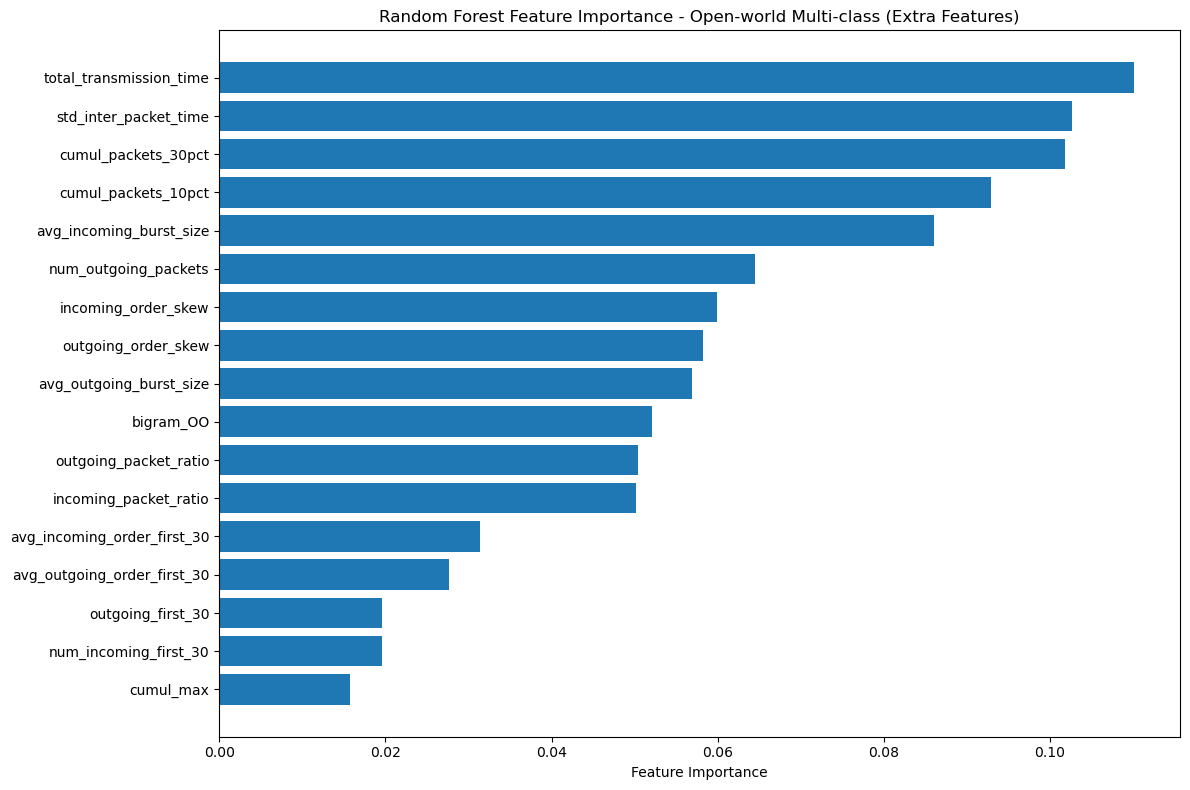

In [13]:
# Feature 중요도 분석
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': rf_clf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature 중요도 (상위 10개):")
print(feature_importance.head(10).to_string(index=False))

# Feature 중요도 시각화
plt.figure(figsize=(12, 8))
plt.barh(range(len(feature_importance)), feature_importance['importance'])
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance - Open-world Multi-class (Extra Features)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
